In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_e_a_mu, plot_compare_metrics

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
normalizer = Normalizer()

# Paper hyperparameters

In [7]:
max_iter = 300
model1 = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
               beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
               filter_kernels=True, filter_sv=True, verbose=10,
               max_iter=max_iter, hyperopt_enabled=False)
pipeline1 = make_pipeline(normalizer, model1)
pipeline1.fit(X_train, y_train)

Iter: 10. Bound: -1419.3128
Iter: 20. Bound: -1321.2787
Iter: 30. Bound: -1275.4666
Iter: 40. Bound: -1257.2298
Iter: 50. Bound: -1233.8619
Iter: 60. Bound: -1215.1290
Iter: 70. Bound: -1194.7802
Iter: 80. Bound: -1181.8822
Iter: 90. Bound: -1162.8119
Iter: 100. Bound: -1151.4308
Iter: 110. Bound: -1146.9118
Iter: 120. Bound: -1135.9528
Iter: 130. Bound: -1131.1680
Iter: 140. Bound: -1129.3502
Iter: 150. Bound: -1127.7482
Iter: 160. Bound: -1125.5122
Iter: 170. Bound: -1122.2995
Iter: 180. Bound: -1121.1072
Iter: 190. Bound: -1120.2403
Iter: 200. Bound: -1119.4841
Iter: 210. Bound: -1118.7022
Iter: 220. Bound: -1117.5625
Iter: 230. Bound: -1114.0811
Iter: 240. Bound: -1113.4432
Iter: 250. Bound: -1112.9541
Iter: 260. Bound: -1112.5214
Iter: 270. Bound: -1112.1134
Iter: 280. Bound: -1111.7106
Iter: 290. Bound: -1111.3015
Iter: 300. Bound: -1110.8773
Iterations total time: 19.4346


Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=1e-06, alpha_gamma=1, alpha_lambda=1, alpha_omega=1,
   beta_gamma=1, beta_lambda=1, beta_omega=1, e_null_thrsh=0.001,
   filter_kernels=True, filter_sv=True, hyperopt_enabled=False,
   hyperopt_every=5, hyperopt_m...ambda> at 0x7f947177bd90>],
   margin=1, max_iter=300, random_state=None, sigma_g=0.1, verbose=10))])

In [8]:
max_iter = 300
ho_model1 = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                 beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
                 filter_kernels=True, filter_sv=True, verbose=10,
                 max_iter=max_iter, hyperopt_enabled=True,
                 hyperopt_max_iter=5, hyperopt_every=5, hyperopt_tol=5)
ho_pipeline1 = make_pipeline(normalizer, ho_model1)
ho_pipeline1.fit(X_train, y_train)

Iter: 10. Bound: -1429.4753
Iter: 20. Bound: -1346.7952
Iter: 30. Bound: -1308.6872
Iter: 40. Bound: -1279.3292
Iter: 50. Bound: -1255.5169
Iter: 60. Bound: -1241.5455
Iter: 70. Bound: -1226.4768
Iter: 80. Bound: -1207.3800
Iter: 90. Bound: -1197.4673
Iter: 100. Bound: -1186.3672
Iter: 110. Bound: -1173.8687
Iter: 120. Bound: -1157.0806
Iter: 130. Bound: -1151.7860
Iter: 140. Bound: -1145.1838
Iter: 150. Bound: -1143.5819
Iter: 160. Bound: -1141.7374
Iter: 170. Bound: -1136.9087
Iter: 180. Bound: -1135.1039
Iter: 190. Bound: -1133.7337
Iter: 200. Bound: -1132.4305
Iter: 210. Bound: -1131.0785
Iter: 220. Bound: -1129.5740
Iter: 230. Bound: -1127.7353
Iter: 240. Bound: -1124.8203
Iter: 250. Bound: -1121.5387
Iter: 260. Bound: -1118.4650
Iter: 270. Bound: -1115.4894
Iter: 280. Bound: -1113.1375
Iter: 290. Bound: -1110.8684
Iter: 300. Bound: -1108.2146
Iterations total time: 350.8712


Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=1e-06, alpha_gamma=0.7348928081465438,
   alpha_lambda=0.9248843778311668, alpha_omega=1.2947730731423897,
   beta_gamma=0.7050207656653206, beta_lambda=1.1576398316031256,
   beta_omega=1.294639254129139, e_null_t...7bd90>],
   margin=1, max_iter=300, random_state=None, sigma_g=0.13220901733771992,
   verbose=10))])

In [9]:
with open('model1.pickle', 'wb') as fp:
    model1.set_params(kernels=None)
    model1.kernels_orig = None
    ho_model1.set_params(kernels=None)
    ho_model1.kernels_orig = None
    pickle.dump({'model1': model1, 'ho_model1': ho_model1, 'normalizer': normalizer}, fp)

In [10]:
with open('model1.pickle', 'rb') as fp:
    models_dict = pickle.load(fp)

model1 = models_dict['model1']
ho_model1 = models_dict['ho_model1']
normalizer = models_dict['normalizer']

In [11]:
model1.set_params(kernels=kernels)
model1.kernels_orig = kernels
ho_model1.set_params(kernels=kernels)
ho_model1.kernels_orig = kernels

In [12]:
[(k, v) for k, v in ho_model1.get_params().items() if k.startswith('alpha') or k.startswith('beta')]

[('alpha_lambda', 0.9248843778311668),
 ('beta_lambda', 1.1576398316031256),
 ('alpha_gamma', 0.7348928081465438),
 ('beta_gamma', 0.7050207656653206),
 ('alpha_omega', 1.2947730731423897),
 ('beta_omega', 1.294639254129139)]

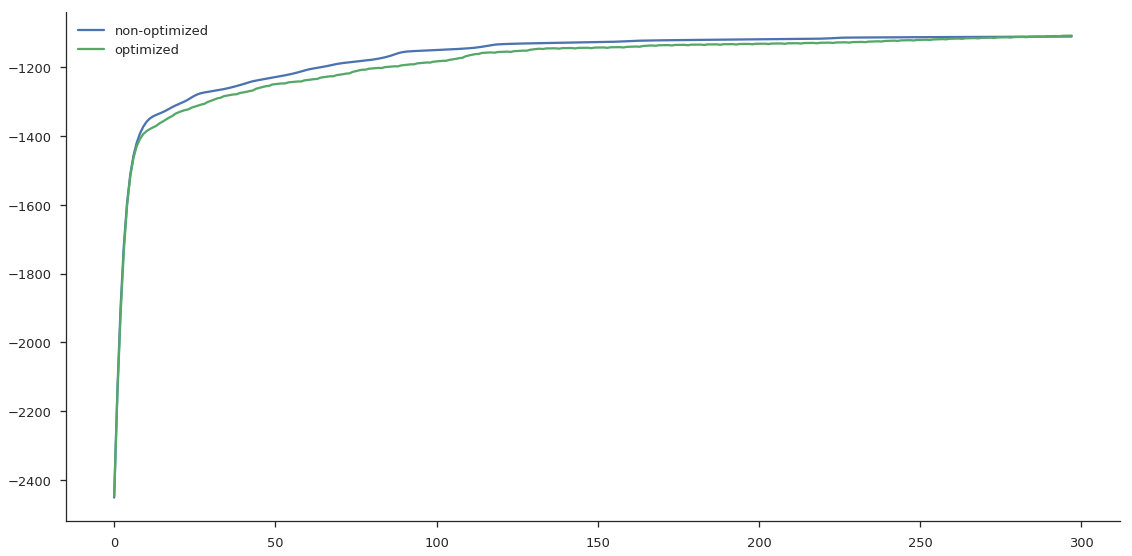

In [13]:
fig = plt.figure(figsize=(16, 8))
ax = fig.gca()
from_iter = 2
ax.plot([b[0] for b in model1.bounds[from_iter:]], label='non-optimized')
ax.plot([b[0] for b in ho_model1.bounds[from_iter:]], label='optimized')
ax.legend()
sns.despine()
plt.tight_layout()

# Bad hyperparameters

In [14]:
max_iter = 300
model10 = BEMKL(kernels=kernels, alpha_lambda=10, beta_lambda=10, alpha_gamma=10,
              beta_gamma=10, alpha_omega=10, beta_omega=10, e_null_thrsh=1e-3,
              filter_kernels=True, filter_sv=True, verbose=10,
              max_iter=max_iter, hyperopt_enabled=False)
pipeline10 = make_pipeline(normalizer, model10)
pipeline10.fit(X_train, y_train)

Iter: 10. Bound: -1980.5573
Iter: 20. Bound: -1551.3204
Iter: 30. Bound: -1477.5766
Iter: 40. Bound: -1446.5541
Iter: 50. Bound: -1379.6072
Iter: 60. Bound: -1271.8346
Iter: 70. Bound: -1206.6227
Iter: 80. Bound: -965.4048
Iter: 90. Bound: -897.0704
Iter: 100. Bound: -880.6632
Iter: 110. Bound: -864.6405
Iter: 120. Bound: -858.8005
Iter: 130. Bound: -854.6052
Iter: 140. Bound: -851.4826
Iter: 150. Bound: -849.0535
Iter: 160. Bound: -847.0734
Iter: 170. Bound: -845.3865
Iter: 180. Bound: -843.8948
Iter: 190. Bound: -842.5365
Iter: 200. Bound: -841.2727
Iter: 210. Bound: -840.0789
Iter: 220. Bound: -838.9393
Iter: 230. Bound: -837.8435
Iter: 240. Bound: -836.7845
Iter: 250. Bound: -835.7574
Iter: 260. Bound: -834.7584
Iter: 270. Bound: -833.7846
Iter: 280. Bound: -832.8339
Iter: 290. Bound: -831.9043
Iter: 300. Bound: -830.9940
Iterations total time: 14.3414


Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=1e-06, alpha_gamma=10, alpha_lambda=10, alpha_omega=10,
   beta_gamma=10, beta_lambda=10, beta_omega=10, e_null_thrsh=0.001,
   filter_kernels=True, filter_sv=True, hyperopt_enabled=False,
   hyperopt_every=5, hype...ambda> at 0x7f947177bd90>],
   margin=1, max_iter=300, random_state=None, sigma_g=0.1, verbose=10))])

In [16]:
max_iter = 300
ho_model10 = BEMKL(kernels=kernels, alpha_lambda=10, beta_lambda=10, alpha_gamma=10,
                 beta_gamma=10, alpha_omega=10, beta_omega=10, e_null_thrsh=1e-3,
                 filter_kernels=True, filter_sv=True, verbose=10,
                 max_iter=max_iter, hyperopt_enabled=True,
                 hyperopt_max_iter=10, hyperopt_every=5, hyperopt_tol=5)
ho_pipeline10 = make_pipeline(normalizer, ho_model10)
ho_pipeline10.fit(X_train, y_train)

HyperParamIter: 10. Bound: -2568.6313176482313
Hyperparams: {'gamma_alpha': 9.991021560483457,
 'gamma_beta': 9.991018687294199,
 'lambda_alpha': 9.991001201396463,
 'lambda_beta': 9.991005103295246,
 'omega_alpha': 9.991058625381529,
 'omega_beta': 9.991065126451842,
 'sigma_g': 0.10053700636433448}
Iter: 10. Bound: -2059.5258
HyperParamIter: 10. Bound: -2003.591190677785
Hyperparams: {'gamma_alpha': 9.981049636333386,
 'gamma_beta': 9.981043063875603,
 'lambda_alpha': 9.98100339373254,
 'lambda_beta': 9.981017128140962,
 'omega_alpha': 9.98113170857213,
 'omega_beta': 9.981152458036346,
 'sigma_g': 0.1010454205952019}
HyperParamIter: 10. Bound: -1780.664935777575
Hyperparams: {'gamma_alpha': 9.971077712383885,
 'gamma_beta': 9.971067394468296,
 'lambda_alpha': 9.971006166617373,
 'lambda_beta': 9.971033876019959,
 'omega_alpha': 9.971204697130725,
 'omega_beta': 9.971245471133166,
 'sigma_g': 0.10155486356508107}
Iter: 20. Bound: -1680.7742
HyperParamIter: 10. Bound: -1642.4438203579

Iter: 140. Bound: -861.9262
HyperParamIter: 10. Bound: -863.0471009240739
Hyperparams: {'gamma_alpha': 9.823049797446227,
 'gamma_beta': 9.722748396531134,
 'lambda_alpha': 9.721333124111196,
 'lambda_beta': 9.931356376321032,
 'omega_alpha': 9.880614965868352,
 'omega_beta': 10.075085004996819,
 'sigma_g': 0.11432584284853013}
HyperParamIter: 10. Bound: -862.4885907573432
Hyperparams: {'gamma_alpha': 9.824491307420539,
 'gamma_beta': 9.712868295316241,
 'lambda_alpha': 9.711348669722051,
 'lambda_beta': 9.941356290414836,
 'omega_alpha': 9.880400851530007,
 'omega_beta': 10.084777695163039,
 'sigma_g': 0.11483731663484918}
Iter: 150. Bound: -860.8457
HyperParamIter: 10. Bound: -861.9579876586347
Hyperparams: {'gamma_alpha': 9.831404265949319,
 'gamma_beta': 9.702931120531453,
 'lambda_alpha': 9.701455415530042,
 'lambda_beta': 9.951356105681135,
 'omega_alpha': 9.880164981879034,
 'omega_beta': 10.094477217119673,
 'sigma_g': 0.11534882662315658}
HyperParamIter: 10. Bound: -861.453089

Iter: 270. Bound: -850.4985
HyperParamIter: 10. Bound: -851.3833122252026
Hyperparams: {'gamma_alpha': 9.935919535686502,
 'gamma_beta': 9.465364794057932,
 'lambda_alpha': 9.732316712411631,
 'lambda_beta': 10.1903678893827,
 'omega_alpha': 9.873744818450897,
 'omega_beta': 10.32883655110582,
 'sigma_g': 0.12763492924140574}
HyperParamIter: 10. Bound: -850.8287056416639
Hyperparams: {'gamma_alpha': 9.93789609228458,
 'gamma_beta': 9.455513296810972,
 'lambda_alpha': 9.733792020355876,
 'lambda_beta': 10.200318790211526,
 'omega_alpha': 9.87340601679179,
 'omega_beta': 10.33865374343052,
 'sigma_g': 0.12814722046602714}
Iter: 280. Bound: -849.3281
HyperParamIter: 10. Bound: -850.1521695676266
Hyperparams: {'gamma_alpha': 9.944755346172187,
 'gamma_beta': 9.445596447402993,
 'lambda_alpha': 9.735572689863131,
 'lambda_beta': 10.210266503648391,
 'omega_alpha': 9.873054552823772,
 'omega_beta': 10.348474421271217,
 'sigma_g': 0.12865953669774338}
HyperParamIter: 10. Bound: -849.092636455

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=1e-06, alpha_gamma=9.956687246999314,
   alpha_lambda=9.75374320882746, alpha_omega=9.871083148942004,
   beta_gamma=9.41501968320208, beta_lambda=10.240987195772826,
   beta_omega=10.378923606471828, e_null_thrsh=...77bd90>],
   margin=1, max_iter=300, random_state=None, sigma_g=0.1301818164839324,
   verbose=10))])

In [17]:
with open('model10.pickle', 'wb') as fp:
    model10.set_params(kernels=None)
    model10.kernels_orig = None
    ho_model10.set_params(kernels=None)
    ho_model10.kernels_orig = None
    pickle.dump({'model10': model10, 'ho_model10': ho_model10, 'normalizer': normalizer}, fp)

In [18]:
with open('model10.pickle', 'rb') as fp:
    models_dict = pickle.load(fp)

model10 = models_dict['model10']
ho_model10 = models_dict['ho_model10']
normalizer = models_dict['normalizer']

model10.set_params(kernels=kernels)
model10.kernels_orig = kernels
ho_model10.set_params(kernels=kernels)
ho_model10.kernels_orig = kernels

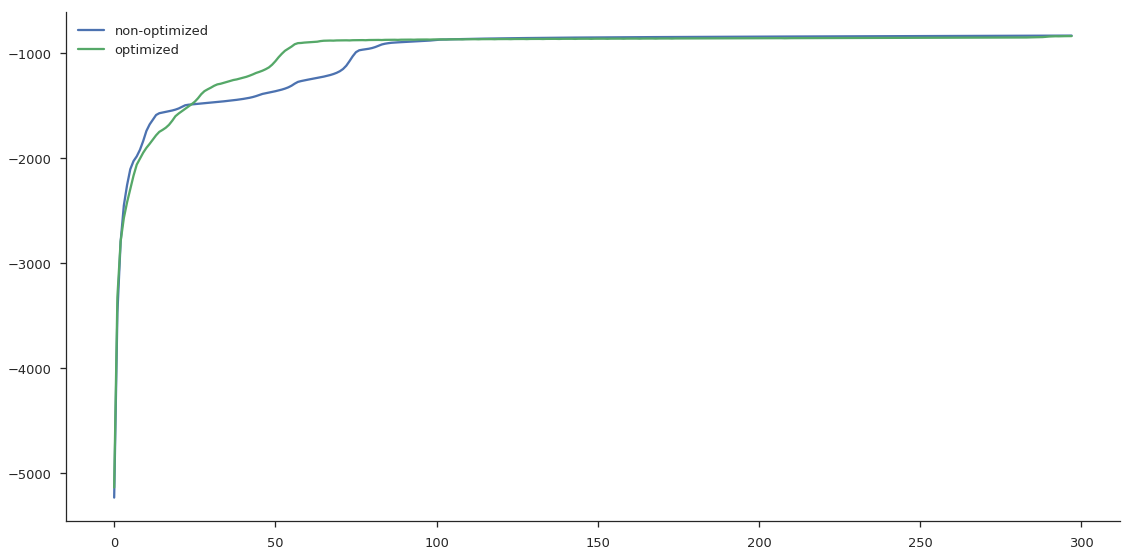

In [19]:
fig = plt.figure(figsize=(16, 8))
ax = fig.gca()
from_iter = 2
ax.plot([b[0] for b in model10.bounds[from_iter:]], label='non-optimized')
ax.plot([b[0] for b in ho_model10.bounds[from_iter:]], label='optimized')
ax.legend()
sns.despine()
plt.tight_layout()